In [60]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns


In [1434]:
# states for a cell
SIDEWALK = 0
OBSTACLE = 1
LITTER = 2
FORWARD = 3
# actions
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3

class World:
    def __init__(self, size=(6,25), sidewalk_rows=(0,2,4)):
        self.size = size
        self.sidewalk = sidewalk_rows
        self.world = np.zeros(shape=size)   
        
    def create_episode(self, rand=False):
        if rand == True:
            self.current_location = (random.randint(0, self.size[0]-1), random.randint(0, self.size[1]-1))
        else:
            self.current_location = (5,24)
            
        self.start_location = self.current_location
        self.time = 0
        self.world = np.zeros(shape=self.size) 
        for i in range(self.size[0]):
            for j in range(self.size[1]):
                p = random.uniform(0, 1)
                if p < .2:
                    self.world[i,j] = LITTER
                elif .2 < p < .4:
                    self.world[i,j] = OBSTACLE
                elif i in self.sidewalk:
                    self.world[i,j] = 0
                else:
                    self.world[i,j] = -1
        self.start_world = self.world.copy()

        
    def bounds(self, tup):
        if (0 <= tup[0] < self.size[0]) and (0 <= tup[1] < self.size[1]):
            return True
        return False
    
    def reset(self):
        self.current_location = self.start_location
        self.world = self.start_world.copy()
        

    # type represents, LITTER, OBSTACLE, SIDEWALK, or FORWARD
    def get_state(self, state_type):
        down = (self.current_location[0]+1,self.current_location[1])
        up = (self.current_location[0]-1,self.current_location[1])
        left = (self.current_location[0],self.current_location[1]-1)
        right = (self.current_location[0],self.current_location[1]+1)
        
        if state_type == FORWARD:
            state = int('0000',2)
            if up[1] == 0:
                state = state | int('0001',2)
            if down[1] == 0:
                state = state | int('0010',2)
            if left[1] == 0:
                state = state | int('0100',2)
            if right[1] == 0:
                state = state | int('1000',2)
                

        if state_type == SIDEWALK:
            state = int('0000',2)
            if up[0] in self.sidewalk:
                state = state | int('0001',2)
            if down[0] in self.sidewalk:
                state = state | int('0010',2)
            if left[0] in self.sidewalk:
                state = state | int('0100',2)
            if right[0] in self.sidewalk:
                state = state | int('1000',2)
            return state
        
        state = int('0000',2)
        if self.bounds(up):
            if self.world[up] == state_type:
                state = state | int('0001',2)
        elif not self.bounds(up) and state_type == OBSTACLE:
            state = state | int('0001',2) 
            
        if self.bounds(down):
            if self.world[down] == state_type:
                state = state | int('0010',2)
        elif not self.bounds(down) and state_type == OBSTACLE:
            state = state | int('0010',2) 
            
        if self.bounds(left):
            if self.world[left] == state_type:
                state = state | int('0100',2)
        elif not self.bounds(left) and state_type == OBSTACLE:
            state = state | int('0100',2) 
            
        if self.bounds(right):
            if self.world[right] == state_type:
                state = state | int('1000',2)
        elif not self.bounds(right) and state_type == OBSTACLE:
            state = state | int('1000',2) 

        return state
    
    # Given an action, find out the rewards for the step taken
    def step(self, action):
        
        forwardReward = 0

        new_state = -1
        if action == DOWN:
            new_state = (self.current_location[0]+1,self.current_location[1])
        if action == UP:
            new_state = (self.current_location[0]-1,self.current_location[1])
        if action == LEFT:
            new_state = (self.current_location[0],self.current_location[1]-1)
            forwardReward += 10
        if action == RIGHT:
            new_state = (self.current_location[0],self.current_location[1]+1)
            forwardReward -= 10
            
        if not self.bounds(new_state):
            return (-100,-100,-100,-100) # if OOB, don't update position and send back a really nasty reward
            
        self.current_location = new_state
        self.time += 1

        
        obstacleReward = 0
        litterReward = -3
        sidewalkReward = 0
            
        # FORWARD REWARD
        if self.current_location[1] == 0:
            forwardReward += 50
            
        # LITTER REWARDS
        if self.world[self.current_location] == LITTER:
            # remove the litter from the world and set it to nothing or a sidewalk if needed
            self.world[self.current_location] = -1
            if self.current_location[0] in self.sidewalk:
                self.world[self.current_location] = SIDEWALK
                
            if action == LEFT:
                litterReward += 3.5
            elif action == RIGHT:
                litterReward -= 2.5
            else:
                litterReward += 3
        else:
            if action == LEFT:
                litterReward += 1
            if action == RIGHT:
                litterReward -= 1
                
        # OBSTACLE REWARDS
        if self.world[self.current_location] == OBSTACLE:
                obstacleReward = -10    
        else:
            if action == LEFT:
                obstacleReward += 3.5 
            elif action == RIGHT:
                obstacleReward -= 2.5 

        # SIDEWALK REWARDS
        if self.current_location[0] in self.sidewalk:
            if action == RIGHT:
                sidewalkReward -= 1
            if action == LEFT:
                sidewalkReward += 10
            sidewalkReward += 10
        else:
            sidewalkReward = -10
            
        return (sidewalkReward, obstacleReward, litterReward, forwardReward)

Text(0.5, 1, 'Sample Environment')

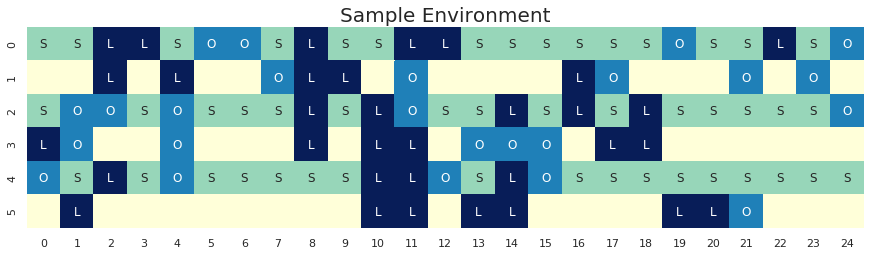

In [1627]:
def mapper(s):
    if s == "1.0":
        return "O"
    if s == "2.0":
        return "L"
    if s == "-1.0":
        return ""
    return "S"

fig, ax = plt.subplots(figsize=(15,15))

ax = sns.heatmap(env.world, annot=True, fmt = '.1f', square=True, cbar=False, cmap="YlGnBu")

for t in ax.texts: 
    t.set_text(mapper(t.get_text()))
    
plt.title("Sample Environment",fontsize=20)


In [1441]:
class QAgent:
    def __init__(self):
        # do nothing
        self.Q = np.random.random(size=(16,4))
        self.initialize();
    def initialize(self, alpha=.1, gamma=.9):
        # initialize the agent's hyperparams
        self.epsilon = .9
        self.epsilon_min = .1
        self.epsilon_decay = 0.0005

        
        self.alpha = alpha
        self.gamma = gamma
        
        
    def normalizeQ(self):
        self.Q =self.Q / np.linalg.norm(self.Q, axis=1,keepdims=True,ord=2)
#         self.Q =self.Q / np.linalg.norm(self.Q, ord=2)


    def step(self, state):
        p = random.uniform(0, 1)
        a = 0
        if p < self.epsilon:
            # we choose a random action
            a = random.randint(0,3)
        else:
            # we choose the best action
            a = np.argmax(self.Q[state,:])
        
        return a
    
    def update(self, s, a, r, sprime):  
        self.Q[s,a] += self.alpha * (r + self.gamma * self.Q[sprime,np.argmax(self.Q[sprime,:])] - self.Q[s,a])
    
    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= (1-self.epsilon_decay)

In [1491]:
for i in range(4):
    print(modules[i].Q)

[[ 6.34877666e-01  4.41044126e-01  5.59961943e-01  2.98082288e-01]
 [ 9.99998335e-01 -4.78623368e-10 -1.82504275e-03 -2.82730111e-31]
 [ 3.87203815e-01  5.73413082e-01  5.82467518e-02  7.19637380e-01]
 [ 8.09751627e-01  5.86772786e-01 -6.90234409e-49 -1.01541389e-17]
 [ 3.22646521e-01  7.66309349e-01  3.52154409e-01  4.29716741e-01]
 [ 1.02347097e-01  3.86181272e-01  6.39599277e-01  6.56735763e-01]
 [ 6.44537833e-01  5.43736880e-01  2.61447427e-02  5.36877677e-01]
 [ 2.16222566e-01  3.60858807e-01  1.93827067e-01  8.86261695e-01]
 [ 5.26243967e-01  3.47685145e-01  7.00085661e-01  3.34757217e-01]
 [ 1.51810703e-01  8.67730134e-01  4.17129216e-01  2.23609351e-01]
 [ 5.89819280e-01  2.46140600e-01  6.10506919e-01  4.67770588e-01]
 [ 2.38508631e-01  5.74718960e-01  7.78067515e-01  8.61550432e-02]
 [-9.30405574e-04 -6.98651608e-04  9.99999323e-01  9.36198444e-06]
 [ 1.79056281e-01  3.64018977e-01  6.94322403e-01  5.94428661e-01]
 [ 7.53736043e-01  3.00417779e-01  3.24220923e-02  5.83592275e

In [1577]:
env = World()

modules = []
for i in range(4):
    modules.append(QAgent())
    
    
for state_type in [SIDEWALK, OBSTACLE, LITTER, FORWARD]:
    agent = modules[state_type]
    disp = 5
    if state_type == SIDEWALK:
        disp = 0
    for episode in range(100000):
        env.create_episode(rand=True)
        for time in range(env.current_location[1] + disp):
            s = env.get_state(state_type)
            a = agent.step(s)
            r = env.step(a)[state_type]
            sprime = env.get_state(state_type)
            agent.update(s,a,r,sprime)
        # normalize Q for this agent
        agent.normalizeQ()
        env.reset()
        agent.update_epsilon()

In [1641]:
env.create_episode()

In [1642]:
env.reset()
state_lists = []
for i,state_type in enumerate([SIDEWALK, OBSTACLE, LITTER, FORWARD]):
# for i,state_type in enumerate([LITTER]):
    state_lists.append([])
    agent = modules[state_type]
    env.reset()
    for time in range(40):
        state_lists[i].append(env.current_location)
        s = env.get_state(state_type)
        a = agent.step(s)
        r = env.step(a)[state_type]
env.reset()


Text(0.5, 1, "Modules' Paths")

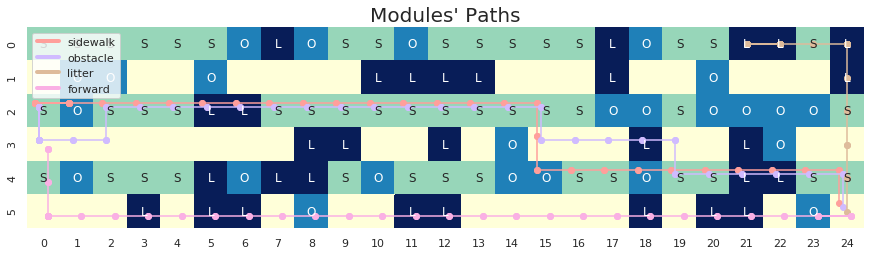

In [1643]:
sns.set()
sns.set_style("white")
sns.set_palette("pastel")
pal = sns.color_palette("pastel")
colors = pal.as_hex()


def mapper(s):
    if s == "1.0":
        return "O"
    if s == "2.0":
        return "L"
    if s == "-1.0":
        return ""
    return "S"

fig, ax = plt.subplots(figsize=(15,15))

ax = sns.heatmap(env.world, annot=True, fmt = '.1f', square=True, cbar=False, cmap="YlGnBu")

labels = ['sidewalk','obstacle','litter','forward']
for state_type in [SIDEWALK, OBSTACLE, LITTER, FORWARD]:
    offset = .25 + state_type*.125
    for i in range(len(state_lists[state_type])-1):
        x1, y1 = [state_lists[state_type][i][1]+offset, state_lists[state_type][i+1][1]+offset], \
                 [state_lists[state_type][i][0]+offset, state_lists[state_type][i+1][0]+offset]
        plt.plot(x1, y1, marker = 'o', color=colors[state_type+3])
        
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=colors[SIDEWALK+3], lw=4),
                Line2D([0], [0], color=colors[OBSTACLE+3], lw=4),
                Line2D([0], [0], color=colors[LITTER+3], lw=4),
                Line2D([0], [0], color=colors[FORWARD+3], lw=4)]
plt.legend(custom_lines,labels)
for t in ax.texts: 
    t.set_text(mapper(t.get_text()))


plt.title("Modules' Paths",fontsize=20)


In [1663]:
# env.create_episode()
def select_action(agents, weights, states):
    weighted_q = np.zeros(4)
    for weight,state,agent in zip(weights,states,agents):
        weighted_q += weight * agent.Q[state,:]
    print(weighted_q)
    return np.argmax(weighted_q)
        
pos = []
# for i,state_type in enumerate([SIDEWALK, OBSTACLE, LITTER, FORWARD]):
# for i,state_type in enumerate([LITTER]):
env.reset()
for time in range(40):
    states = []
    pos.append(env.current_location)
    for i,state_type in enumerate([SIDEWALK, OBSTACLE, LITTER, FORWARD]):
        states.append(env.get_state(state_type))
#     print(states)
    a = select_action(modules, [.4,.2,.3,.1],states)
#     print(a)
    env.step(a)
env.reset()

[ 0.33185676 -0.40655036 -0.09397717 -0.2705123 ]
[-0.14210213 -0.22561356  0.51541958 -0.18867209]
[-0.30622814 -0.15699456  0.67485224 -0.01657073]
[-0.30622816 -0.08646796  0.6876999  -0.01656014]
[-0.08026487 -0.16518745  0.5074735  -0.24461623]
[-0.13717392 -0.18273115  0.5282504  -0.22483323]
[-0.13124533 -0.2256009   0.11575053 -0.18488145]
[-0.08026487 -0.16518745  0.5074735  -0.24461623]
[-0.14210213 -0.22561356  0.51541958 -0.18867209]
[-0.13124533 -0.2256009   0.11575053 -0.18488145]
[-0.13124533 -0.2256009   0.11575053 -0.18488145]
[-0.14225878 -0.22562416  0.51414296 -0.20775249]
[-0.14210213 -0.22561356  0.51541958 -0.18867209]
[-0.08026487 -0.16518745  0.5074735  -0.24461623]
[-0.12631627 -0.18270771  0.12854749 -0.22391047]
[-0.14210298 -0.22562433  0.51545344 -0.18580421]
[-0.04542376 -0.2969153   0.698441   -0.21385153]
[-0.0454246  -0.36745272  0.68562936 -0.21005612]
[-0.13124533 -0.2256009   0.11575053 -0.18488145]
[-0.28211549 -0.09987687  0.67719599 -0.1282144 ]


Text(0.5, 1, 'Weighted Sums of Modules')

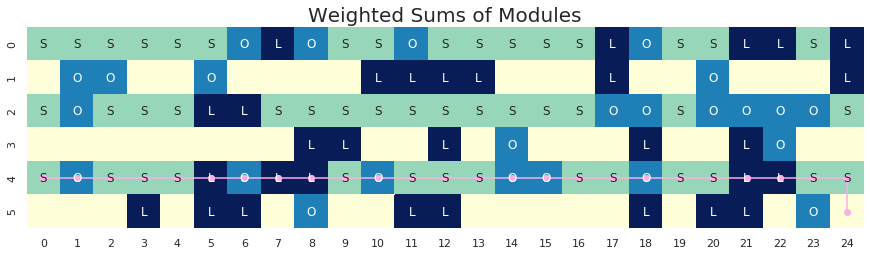

In [1664]:
sns.set()
sns.set_style("white")
sns.set_palette("pastel")
pal = sns.color_palette("pastel")
colors = pal.as_hex()


def mapper(s):
    if s == "1.0":
        return "O"
    if s == "2.0":
        return "L"
    if s == "-1.0":
        return ""
    return "S"

fig, ax = plt.subplots(figsize=(15,15))

ax = sns.heatmap(env.world, annot=True, fmt = '.1f', square=True, cbar=False, cmap="YlGnBu")

labels = ['sidewalk','obstacle','litter','forward']
offset = .5
for i in range(len(pos)-1):
    x1, y1 = [pos[i][1]+offset, pos[i+1][1]+offset], \
             [pos[i][0]+offset, pos[i+1][0]+offset]
    plt.plot(x1, y1, marker = 'o', color=colors[state_type+3])
        
for t in ax.texts: 
    t.set_text(mapper(t.get_text()))
plt.title("Weighted Sums of Modules with an issue",fontsize=20)
